In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
import gensim
from scipy.linalg import triu
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score, log_loss
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

In [5]:
df = pd.read_csv('./training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=["target", "ids", "date", "flag", "user", "text"])
print(df.head())

   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


In [6]:
print(df.info(),"\n\n")
print(df["target"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
None 


target
0    800000
4    800000
Name: count, dtype: int64


In [7]:
#NOTE: Working with 2.5% of the data, i.e. 40k rows, since working with the entire dataset constantly lead to my kernel timing out.

sample_size = 0.025
train, data = train_test_split(df, test_size=sample_size, stratify=df['target'], random_state=42)

In [8]:
print(data.head(),"\n\n")
print(data.tail())

         target         ids                          date      flag  \
1213677       4  1989373908  Mon Jun 01 01:18:11 PDT 2009  NO_QUERY   
1182767       4  1982310946  Sun May 31 10:57:23 PDT 2009  NO_QUERY   
1512898       4  2175286697  Mon Jun 15 00:34:27 PDT 2009  NO_QUERY   
245739        0  1982077416  Sun May 31 10:28:56 PDT 2009  NO_QUERY   
1088460       4  1969602095  Sat May 30 00:34:33 PDT 2009  NO_QUERY   

                    user                                               text  
1213677     jadeylicious  On the bus, on the way home. Excited for tmr's...  
1182767          katja_b    school almost ends!! can't wait for the summer   
1512898        lizsterrr  for one, it's 3:34 in the morning. and for two...  
245739         Saint8188  Missing the parental unit (my mom) prettiest l...  
1088460  xGeorgiaEloisex  YAAAAAAAY. my animal crossing i ordered off eb...   


         target         ids                          date      flag  \
106147        0  1823413884  Sa

In [9]:
print(data.info(),"\n\n")
print(data["target"].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 40000 entries, 1213677 to 1317992
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  40000 non-null  int64 
 1   ids     40000 non-null  int64 
 2   date    40000 non-null  object
 3   flag    40000 non-null  object
 4   user    40000 non-null  object
 5   text    40000 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.1+ MB
None 


target
4    20000
0    20000
Name: count, dtype: int64


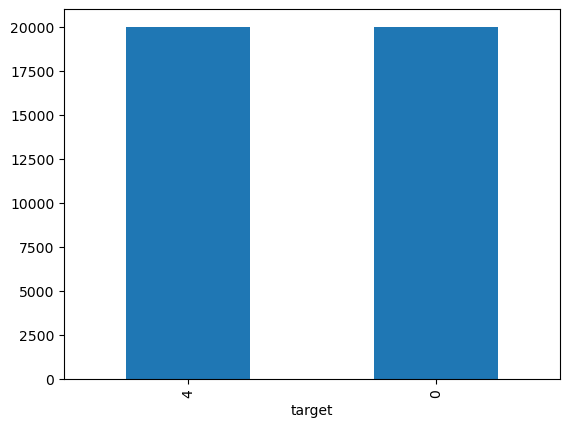

In [10]:
counts = data['target'].value_counts()
counts.plot(kind='bar')
plt.show()


         target         ids                          date      flag  \
1213677       4  1989373908  Mon Jun 01 01:18:11 PDT 2009  NO_QUERY   
1182767       4  1982310946  Sun May 31 10:57:23 PDT 2009  NO_QUERY   
1512898       4  2175286697  Mon Jun 15 00:34:27 PDT 2009  NO_QUERY   
245739        0  1982077416  Sun May 31 10:28:56 PDT 2009  NO_QUERY   
1088460       4  1969602095  Sat May 30 00:34:33 PDT 2009  NO_QUERY   

                    user                                               text  \
1213677     jadeylicious  On the bus, on the way home. Excited for tmr's...   
1182767          katja_b    school almost ends!! can't wait for the summer    
1512898        lizsterrr  for one, it's 3:34 in the morning. and for two...   
245739         Saint8188  Missing the parental unit (my mom) prettiest l...   
1088460  xGeorgiaEloisex  YAAAAAAAY. my animal crossing i ordered off eb...   

                                              cleaned_text  
1213677  on the bus on the way home e

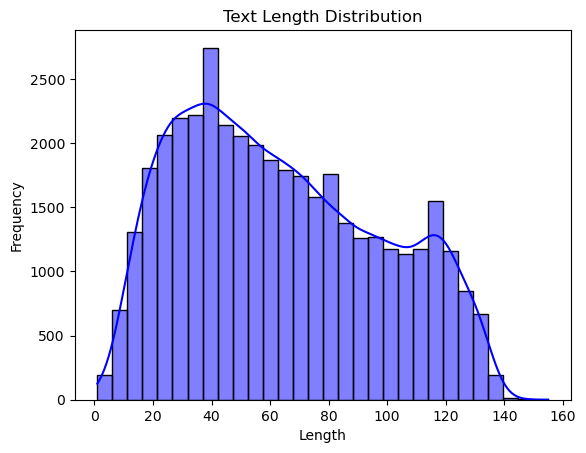

In [11]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)  # Remove mentions and hashtags
    text = re.sub(r"[^A-Za-z\s]", "", text)  # Remove special characters
    return text.lower()

data["cleaned_text"] = data["text"].apply(clean_text)
print(data.head())

data["text_length"] = data["cleaned_text"].str.len()
sns.histplot(data["text_length"], bins=30, kde=True, color="blue")
plt.title("Text Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

In [12]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Westen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [13]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    return " ".join(tokens)

data["processed_text"] = data["cleaned_text"].apply(preprocess_text)
print(data.head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Westen\AppData\Roaming\nltk_data...


[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Westen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Westen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


         target         ids                          date      flag  \
1213677       4  1989373908  Mon Jun 01 01:18:11 PDT 2009  NO_QUERY   
1182767       4  1982310946  Sun May 31 10:57:23 PDT 2009  NO_QUERY   
1512898       4  2175286697  Mon Jun 15 00:34:27 PDT 2009  NO_QUERY   
245739        0  1982077416  Sun May 31 10:28:56 PDT 2009  NO_QUERY   
1088460       4  1969602095  Sat May 30 00:34:33 PDT 2009  NO_QUERY   

                    user                                               text  \
1213677     jadeylicious  On the bus, on the way home. Excited for tmr's...   
1182767          katja_b    school almost ends!! can't wait for the summer    
1512898        lizsterrr  for one, it's 3:34 in the morning. and for two...   
245739         Saint8188  Missing the parental unit (my mom) prettiest l...   
1088460  xGeorgiaEloisex  YAAAAAAAY. my animal crossing i ordered off eb...   

                                              cleaned_text  text_length  \
1213677  on the bus on 

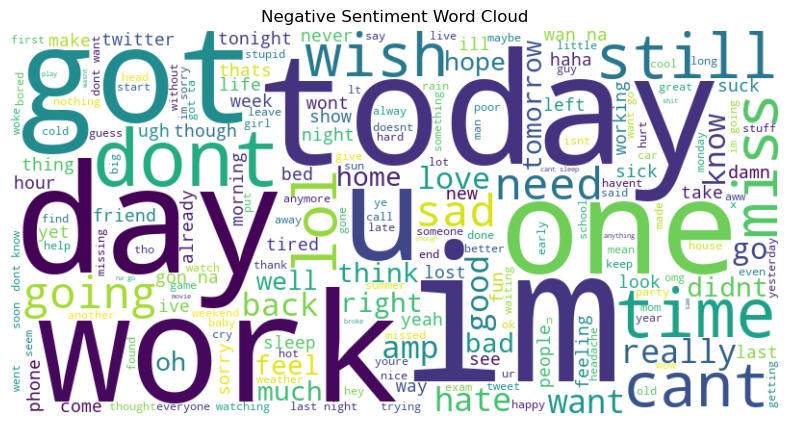

No data available to generate a word cloud for Neutral sentiment.


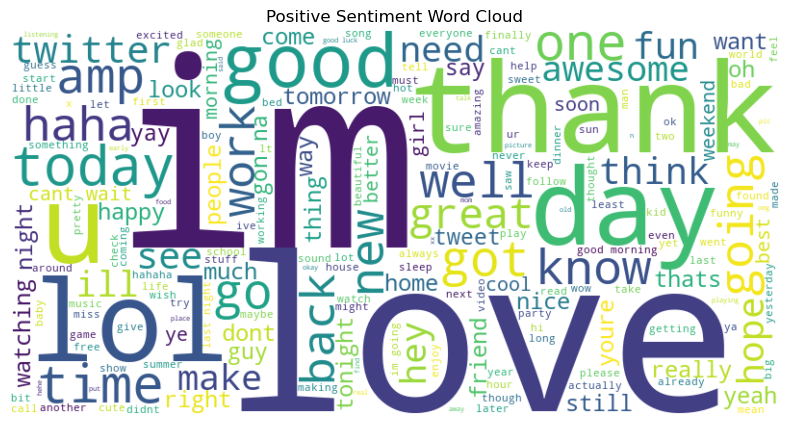

In [14]:
for sentiment, label in zip([0, 2, 4], ["Negative", "Neutral", "Positive"]):
    sentiment_data = data[data["target"] == sentiment]
    if sentiment_data["processed_text"].str.strip().str.len().sum() == 0:
        text = " ".join(sentiment_data["cleaned_text"])
    else:
        text = " ".join(sentiment_data["processed_text"])
    
    if text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(f"{label} Sentiment Word Cloud")
        plt.axis("off")
        plt.show()
    else:
        print(f"No data available to generate a word cloud for {label} sentiment.")

C:\Users\Westen\AppData\Local\Temp\ipykernel_2608\4189511402.py:1: FutureWarning: Parsed string "Mon Jun 01 01:18:11 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  data["date"] = pd.to_datetime(data["date"])


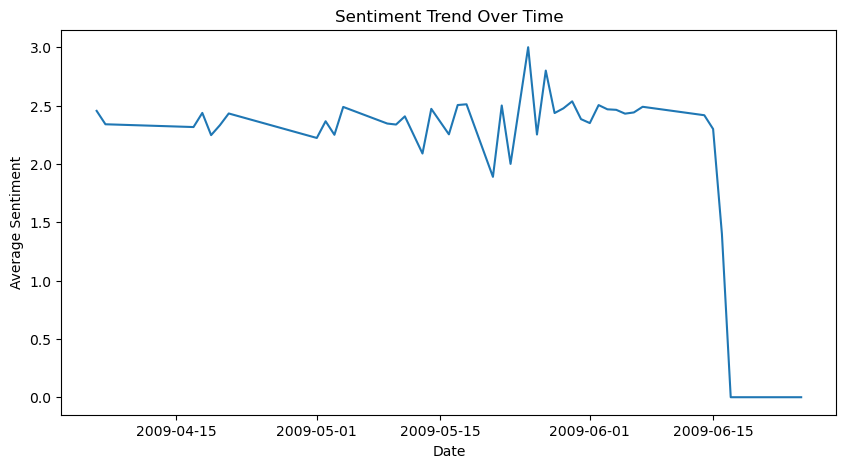

In [15]:
data["date"] = pd.to_datetime(data["date"])
trend_data = data.groupby(data["date"].dt.date)["target"].mean()

trend_data.plot(kind="line", figsize=(10, 5), title="Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Average Sentiment")
plt.show()

In [13]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
dtm = vectorizer.fit_transform(data["processed_text"])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx+1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topic 1:
['night', 'work', 'today', 'going', 'im', 'tomorrow', 'hope', 'morning', 'day', 'good']
Topic 2:
['looking', 'youre', 'home', 'hey', 'fun', 'day', 'nice', 'look', 'like', 'im']
Topic 3:
['wan', 'movie', 'sad', 'new', 'im', 'make', 'gon', 'lol', 'miss', 'na']
Topic 4:
['today', 'bed', 'hour', 'need', 'like', 'sleep', 'going', 'time', 'got', 'im']
Topic 5:
['thanks', 'oh', 'lol', 'like', 'twitter', 'want', 'im', 'know', 'dont', 'love']


In [14]:
tokens = [text.split() for text in data["processed_text"]]
dictionary = Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]

lda_model = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary, random_state=42)

coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary, coherence="c_v")
coherence_score = coherence_model_lda.get_coherence()
print(f"LDA Coherence Score: {coherence_score}")

perplexity = lda_model.log_perplexity(corpus)
print(f"LDA Perplexity: {perplexity}")

LDA Coherence Score: 0.3672047637302877
LDA Perplexity: -8.68330858560025


              precision    recall  f1-score   support

           0       0.77      0.73      0.75      4072
           4       0.73      0.77      0.75      3928

    accuracy                           0.75      8000
   macro avg       0.75      0.75      0.75      8000
weighted avg       0.75      0.75      0.75      8000



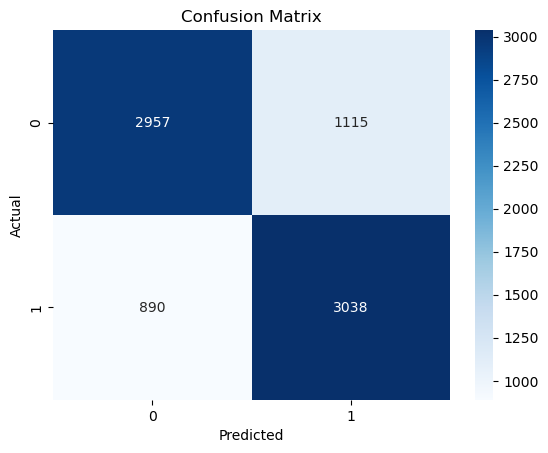

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data["processed_text"], data["target"], test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

lr_clf = LogisticRegression()
lr_clf.fit(X_train_tfidf, y_train)

y_pred = lr_clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [17]:
svm_clf = SVC(kernel="linear", probability=True, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

svm_clf.fit(X_train_tfidf, y_train)
rf_clf.fit(X_train_tfidf, y_train)

svm_pred = svm_clf.predict(X_test_tfidf)
rf_pred = rf_clf.predict(X_test_tfidf)

In [18]:
print("Logistic Regression Performance:")
print(classification_report(y_test, lr_clf.predict(X_test_tfidf)))

print("SVM Performance:")
print(classification_report(y_test, svm_pred))

print("Random Forest Performance:")
print(classification_report(y_test, rf_pred))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      4072
           4       0.73      0.77      0.75      3928

    accuracy                           0.75      8000
   macro avg       0.75      0.75      0.75      8000
weighted avg       0.75      0.75      0.75      8000

SVM Performance:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74      4072
           4       0.73      0.77      0.75      3928

    accuracy                           0.75      8000
   macro avg       0.75      0.75      0.75      8000
weighted avg       0.75      0.75      0.75      8000

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.74      0.73      0.73      4072
           4       0.72      0.74      0.73      3928

    accuracy                           0.73      8000
   macro avg       0.73      0.73      0.73      80

In [26]:
lr_acc = accuracy_score(y_test, lr_clf.predict(X_test_tfidf))
svm_acc = accuracy_score(y_test, svm_pred)
rf_acc = accuracy_score(y_test, rf_pred)

In [27]:
print(f"Logistic Regression Accuracy: {lr_acc}")
print(f"SVM Accuracy: {svm_acc}")
print(f"Random Forest Accuracy: {rf_acc}")

Logistic Regression Accuracy: 0.749375
SVM Accuracy: 0.74625
Random Forest Accuracy: 0.732375


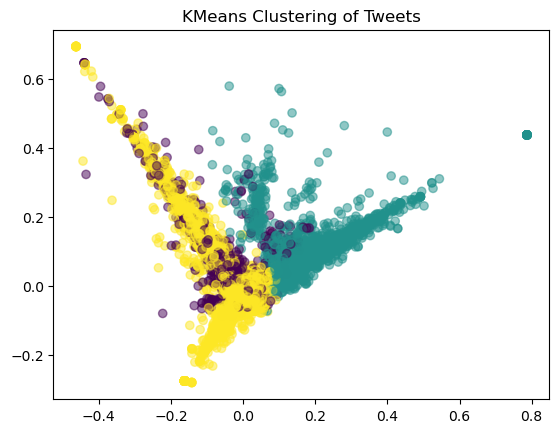

In [21]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_train_tfidf)

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_train_tfidf.toarray())
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap="viridis", alpha=0.5)
plt.title("KMeans Clustering of Tweets")
plt.show()

In [22]:
sil_score = silhouette_score(X_train_tfidf, clusters)
print(f"Silhouette Score for K-Means: {sil_score}")

print(f"Inertia for K-Means: {kmeans.inertia_}")

Silhouette Score for K-Means: 0.006858246578504854
Inertia for K-Means: 31107.942573022443


                 count      mean
user                            
webwoke             11  0.727273
lost_dog            11  0.000000
SarahSaner          10  3.200000
ramdomthoughts       8  4.000000
enamoredsoul         8  3.000000
mcraddictal          8  0.000000
maynaseric           7  3.428571
SallytheShizzle      7  0.571429
leighannirvine       7  0.000000
insearchofnkotb      7  2.285714


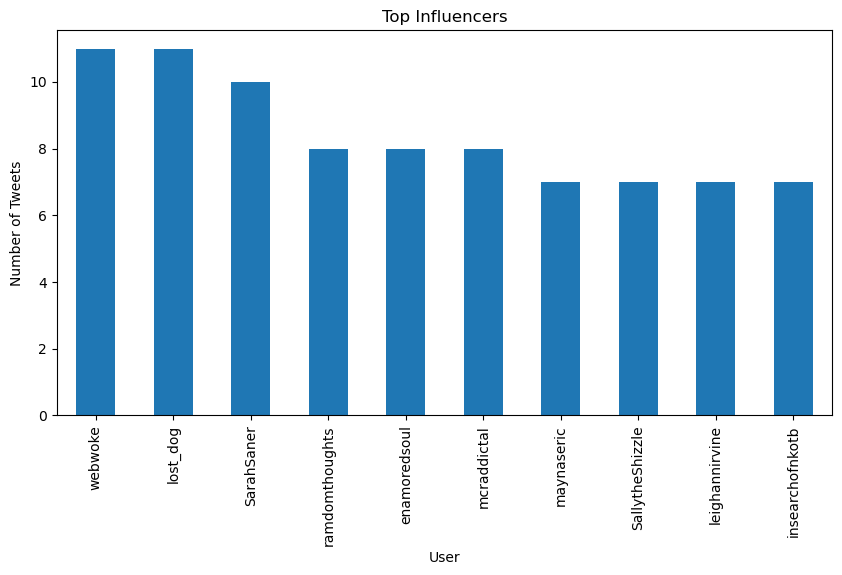

In [23]:
top_users = data.groupby("user")["target"].agg(["count", "mean"]).sort_values(by="count", ascending=False).head(10)
print(top_users)

top_users["count"].plot(kind="bar", figsize=(10, 5), title="Top Influencers")
plt.xlabel("User")
plt.ylabel("Number of Tweets")
plt.show()

In [31]:
import pickle

with open('lr_model.pkl', 'wb') as f:
    pickle.dump(lr_clf, f)

with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_clf, f)

with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

In [2]:
import mlflow
import mlflow.sklearn

In [ ]:
mlflow.set_experiment("Twitter Sentiment Classifier Models")

# Logistic Regression
with mlflow.start_run(run_name="Logistic Regression Model"):
    mlflow.sklearn.log_model(lr_clf, artifact_path="lr_model.pkl", registered_model_name="logistic_regression_model")
    mlflow.log_param("model_type", "logistic_regression")
    mlflow.log_metric("accuracy", lr_acc)

# SVM
with mlflow.start_run(run_name="SVM Model"):
    mlflow.sklearn.log_model(svm_clf, artifact_path="svm_model.pkl", registered_model_name="svm_model")
    mlflow.log_param("model_type", "svm")
    mlflow.log_metric("accuracy", svm_acc)

# Random Forest
with mlflow.start_run(run_name="Random Forest Model"):
    mlflow.sklearn.log_model(rf_clf, artifact_path="rf_model.pkl", registered_model_name="random_forest_model")
    mlflow.log_param("model_type", "random_forest")
    mlflow.log_metric("accuracy", rf_acc)

# KMeans
with mlflow.start_run(run_name="KMeans Clustering"):
    mlflow.sklearn.log_model(kmeans, artifact_path="kmeans_model.pkl", registered_model_name="kmeans_model")
    mlflow.log_param("model_type", "kmeans")
    mlflow.log_param("n_clusters", kmeans.n_clusters)

Registered model 'logistic_regression_model' already exists. Creating a new version of this model...
Created version '3' of model 'logistic_regression_model'.
Successfully registered model 'svm_model'.
Created version '1' of model 'svm_model'.
Successfully registered model 'random_forest_model'.
Created version '1' of model 'random_forest_model'.
Successfully registered model 'kmeans_model'.
Created version '1' of model 'kmeans_model'.
